# Construcción de una Red Neuronal para el Reconocimiento de Dígitos Manuscritos

<div style="text-align: center;">
    <img src="images/numbers.png" style="width: 100%; height: 400px;d" alt="Imagen recortada">
</div>




## 1. Introducción

En este proyecto, se desarrollará una ed neuronal artificial. Este es un primer acercamiento al diseño e implementación de modelos de aprendizaje profundo. La arqitectura de la red neuronal será simple, estará compuesta por tres capas, una primera de aplanamiento, una capa densa oculta y por último una capa de salida.

Se utilizará el conjunto de datos `MNIST`, que es un estándar en el campo del deep learning y computer vision. Este dataset contiene 70000 imágenes en escala de grises de dígitos escritos a mano, divididas en 60000 imágenes para entrenamiento y 10000 imágenes para prueba.

Cada imágen tiene un tamaño de 28x28 píxeles y representa un único dígito del 0 al 9. El objetivo es que la red neuronal clasifique correctamente cada imagen en la categoría correspondiente.

## 2. Importación de las Librerías

In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report


## 3. Carga de los Datos

In [28]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## 4. Exploración del Conjunto de Datos

Empezamos imprimiendo por pantalla las dimensiones de las matrces de entrenamisnto y prueba.

In [29]:
print("Tamaño de los datos de entrenamiento:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

Tamaño de los datos de entrenamiento:
X_train: (60000, 28, 28), y_train: (60000,)


In [30]:
print("Tamaño de los datos de prueba:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Tamaño de los datos de prueba:
X_test: (10000, 28, 28), y_test: (10000,)


Queda comprobado que es cierto que para el entrenamiento disponemos de 60000 ejemplares de 28x28 y para la prueba de 10000.

Ahora, nos centraremos en las clases presentes en las etiquetas y sus frecuencias. 

In [31]:
print("Primeras 20 etiquetas:")
print(y_train[:20])

Primeras 20 etiquetas:
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


Debemos tener en cuenta que si el conjunto de entrenamiento son 60000 y tenemos 10 dígitos (del 0 al 9) nos deberían tocar un total de 6000 ejemplos por clase para tener un conjunto perfectamente balanceado.

In [32]:
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de las clases:")
print(dict(zip(unique, counts)))

Distribución de las clases:
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


La clase con más ejemplos es el dígito 1, con 6742 imágenes, y la que menos es el dígito 5, con 5421 imágenes. El conjunto de datos no está perfectamente equilibrado, pero las diferencias no son demasiado pronunciadas.

Para entender mejor el formato de los datos, nos puede ser útil visualizar las imágenes y sus etiquetas.

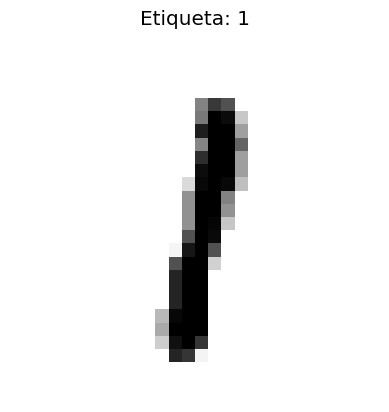

In [33]:
def display_digit(X_train, y_train, num):
  image = X_train[num, :, :]
  label = y_train[num]
  # Visualizamos
  plt.title("Etiqueta: " + str(label))
  plt.imshow(image, cmap=plt.get_cmap("gray_r"))
  plt.axis("off")
  plt.show()

display_digit(X_train=X_train, y_train=y_train, num=1200)

Y por último, analicemos estadísticas básicas como los valores mínimo, máximo, la media y la desviación estándar de los píxeles, de esa manera podemos obtener información fundamental en el caso de tener que preparar los datos adecuadamente.

In [34]:
print(f"Valor mínimo: {X_train.min()}")
print(f"Valor máximo: {X_train.max()}")
print(f"Promedio: {X_train.mean():.2f}")
print(f"Desviación estándar: {X_train.std():.2f}")

Valor mínimo: 0
Valor máximo: 255
Promedio: 33.32
Desviación estándar: 78.57


## 5. Preparación de los Datos

Comenzamos estandarizando los datos, para que los valores queden entre 0 y 1

In [35]:
X_train_norm, X_test_norm = X_train/255, X_test/255

Como estamos trabajando con datos categóricos, lo mejor es hacer un one-hot-encoding de las etiquetas, es decir, convertir cada categoría en un vector.

In [36]:
y_train_ohe = to_categorical(y_train, num_classes=10)
y_test_ohe = to_categorical(y_test, num_classes=10)


# Imprimimos por pantalla uno de esos vectores
print(y_train_ohe[12000, :])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


El vector que hemos sacado por pantalla corresponde al del dígito 7.

Por último, nos queda separar los datos de entrenamiento en entrenamieto y validación.

In [37]:
X_train_tr, X_val, y_train_tr, y_val = train_test_split(X_train_norm, y_train_ohe, 
                                        test_size=0.15, random_state=42)


print("Datos divididos:")
print("Entrenamiento:", X_train_tr.shape)
print("Validación:",X_val.shape)


Datos divididos:
Entrenamiento: (51000, 28, 28)
Validación: (9000, 28, 28)


## 6.Construcción de la Red Neuronal

Esta primera red neuronal tendrá una arquitectura simple. Constará de tres capas secuenciales:
- `Capa de Entrada Flatten`: Convertirá nuestra matriz 2D en un vector 1D.

- `Capa Oculta Densa`: Una capa que estará completamente conectada a las neuronas de la capa anterior y que tendrá una función de activación ReLU para introducir la no linealidad.

- `Capa de Salida`: Una capa de 10 neuronas conectada completamente a la anterior y con una función de activación Softmax que nos convierte la salida en probabilidades normalizadas para cada clase.

In [38]:
model = Sequential()

model.add(Flatten(input_shape=(28,28)))
model.add(Dense(512, activation="relu"))
model.add(Dense(10, activation="softmax"))


model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


El número 512 no es arbitrario; surge de la experimentación previa con redes neuronales en problemas como MNIST. Los modelos preentrenados y los estudios sugieren que una capa densa con 512 neuronas es un buen punto de partida para clasificar imágenes pequeñas con pocos datos.

## 7. Compilación del Modelo

Vamos a definir una tasa de aprendizaje para el optimizador de 0.005, la función de pérdda será la categorical_crossentropy pues estamos en un problema de clasificación multiclase donde las clases son exclusivas (una sola clase correcta por muestra). Como algoritmo de optimización usaremos el clásico SGD (Stochastic Gradient Descent), y la métrica que usaremos será la precisión.

In [39]:
lr = 0.005
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr),
              metrics=["accuracy"])

## 8. Entrenamiento del Modelo

Para el entrenamiento vamos a realizaar 50 épocas y tomar 128 batches, que suelen ser los valores típicos.

In [40]:
print("[INFO]: Entrenando red neuronal...")
epochs, batch_size = 50, 128
H = model.fit(X_train_tr, y_train_tr,
              validation_data=(X_val, y_val),
              epochs=epochs, batch_size=batch_size)

[INFO]: Entrenando red neuronal...
Epoch 1/50
399/399 [==============================] - 2s 5ms/step - loss: 1.4967 - accuracy: 0.6679 - val_loss: 0.9868 - val_accuracy: 0.8066
Epoch 2/50
399/399 [==============================] - 2s 4ms/step - loss: 0.7891 - accuracy: 0.8397 - val_loss: 0.6642 - val_accuracy: 0.8500
Epoch 3/50
399/399 [==============================] - 2s 4ms/step - loss: 0.5920 - accuracy: 0.8632 - val_loss: 0.5430 - val_accuracy: 0.8658
Epoch 4/50
399/399 [==============================] - 2s 4ms/step - loss: 0.5054 - accuracy: 0.8756 - val_loss: 0.4788 - val_accuracy: 0.8776
Epoch 5/50
399/399 [==============================] - 2s 4ms/step - loss: 0.4557 - accuracy: 0.8839 - val_loss: 0.4391 - val_accuracy: 0.8851
Epoch 6/50
399/399 [==============================] - 2s 4ms/step - loss: 0.4228 - accuracy: 0.8903 - val_loss: 0.4112 - val_accuracy: 0.8886
Epoch 7/50
399/399 [==============================] - 2s 4ms/step - loss: 0.3990 - accuracy: 0.8945 - val_loss: 0

## 9. Gráficas de Observación del Proceso

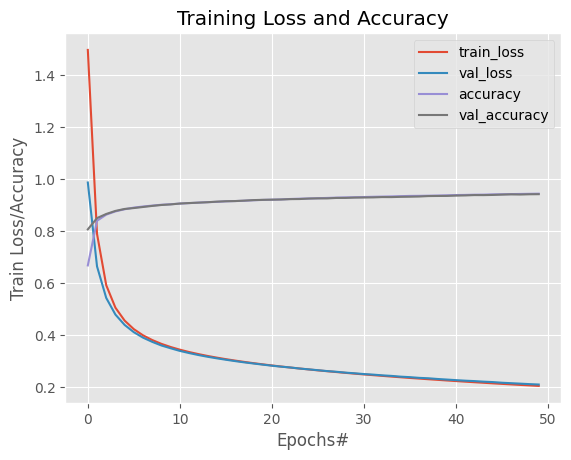

In [41]:
def visualiza_learning_curve(H):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, len(H.history["loss"])), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, len(H.history["loss"])), H.history["accuracy"], label="accuracy")
  plt.plot(np.arange(0, len(H.history["loss"])), H.history["val_accuracy"], label="val_accuracy")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epochs#")
  plt.ylabel("Train Loss/Accuracy")
  plt.legend()

visualiza_learning_curve(H)

El modelo está entrenando correctamente, ya que tanto la pérdida como la precisión continúan mejorando a lo largo de las épocas.Por otro lado, la precisión de validación está aumentando de forma más lenta, lo cual es normal, pero podría sugerir que un poco de sobreajuste está comenzando a ocurrir.

## 10. Evaluación del Modelo

In [42]:
print("[TEST]: Testeando nuestra red...")
yhat_test = model.predict(X_test_norm)
print(yhat_test.shape)
print(np.round(yhat_test[100, :], 2))
print(y_test_ohe[100, :])
print(classification_report(np.argmax(y_test_ohe, -1),
                            np.argmax(yhat_test, -1)
                            ))

[TEST]: Testeando nuestra red...
313/313 [==============================] - 0s 1ms/step
(10000, 10)
[0.   0.   0.03 0.   0.   0.   0.95 0.   0.01 0.  ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.95      0.93      0.94      1032
           3       0.93      0.94      0.93      1010
           4       0.93      0.95      0.94       982
           5       0.94      0.90      0.92       892
           6       0.94      0.96      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.91      0.93      0.92       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



El modelo tiene un rendimiento excelente en el conjunto de test, con una precisión de 0.94, lo que significa que el modelo es bastante preciso al clasificar los números en el conjunto de test.

El modelo tiene un rendimiento consistente en todas las clases, con los F1-scores muy cercanos a 1 en la mayoría de las clases.

Aunque el rendimiento es muy bueno, el recall para algunas clases (como la clase 5, con un 0.90) podría mejorarse aún más. 

## 11. Conclusiones

En general, el modelo muestra una excelente capacidad para generalizar a datos no vistos, sin sobreajuste, y ha sido entrenado de manera adecuada con 50 épocas y 128 muestras por lote. Aunque el rendimiento es muy alto, siempre hay espacio para experimentar con nuevas arquitecturas o técnicas para mejorar aún más la precisión y la velocidad de convergencia en escenarios más complejos.

<!-- ## 5. Preparación de los Datos -->